In [1]:
import sys
import geopandas as gpd
import pandas as pd
import fiona
from shapely.geometry import Polygon
from shapely.ops import transform
import math
import pyproj
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

### Functions neccessary for filtering out geometries with dateline crossings

In [4]:
def check_crossing(lon1: float, lon2: float, validate: bool = True):
    """
    Assuming a minimum travel distance between two provided longitude coordinates,
    checks if the 180th meridian (antimeridian) is crossed.
    """
    if validate and any(abs(x) > 180.0 for x in [lon1, lon2]):
        raise ValueError("longitudes must be in degrees [-180.0, 180.0]")   
    return abs(lon2 - lon1) > 180.0

def check_for_geom(geom):
    crossed = False
    p_init = geom.exterior.coords[0]

    for p in range(1, len(geom.exterior.coords)):
        px = geom.exterior.coords[p]
        # print(px)

        if check_crossing(p_init[0], px[0]):
            crossed = True
        p_init = px
    
    return crossed

In [12]:
fiona.listlayers(r'd:\UTCloud\DGGS\grids\grids.gpkg')

['DGGRID_ISEA4H_7',
 'DGGRID_ISEA3H_9',
 'rhpix_5',
 'DGGRID_ISEA7H_5',
 'rhpix_5_anomalies',
 'DGGRID_ISEA7H_5_anomalies',
 'DGGRID_ISEA3H_9_clean',
 'DGGRID_ISEA4D_7',
 'DGGRID_FULLER_4D',
 'H3_4',
 'EAGGR4T_7',
 'DGGRID_FULLER_7H',
 's2_8',
 'DGGRID_FULLER_4D_clean',
 'DGGRID_ISEA7H_5_clean',
 'DGGRID_FULLER_7H_clean',
 'rhpix_5_clean',
 's2_8_clean',
 'DGGRID_FULLER_4T',
 'DGGRID_ISEA4T_7',
 'DGGRID_ISEA4D_7_clean']

In [7]:
world_countries = gpd.read_file(r'd:\UT\GISData\NaturalEarth\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp')

## Standardized area calculation

### H3

In [3]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='H3_4', driver='GPKG').dropna()

In [4]:
h3_graph = grid.drop('geometry',axis=1)

In [3]:
len(grid)

287525

In [50]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [27]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

C:\Users\Iam\Anaconda3\envs\dggs\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


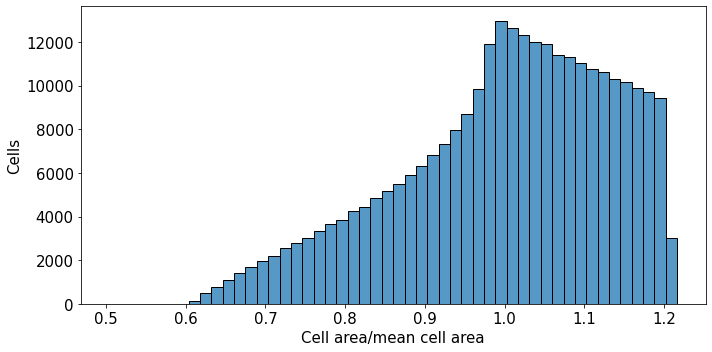

In [62]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cell area/mean cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area.png', bbox_inches="tight",dpi=300)

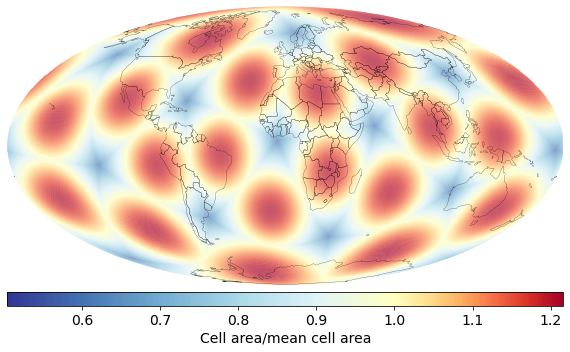

In [63]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
vmin, vmax, vcenter = grid['std_area'].min(), grid['std_area'].max(), 1
norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area_map.png', bbox_inches="tight",dpi=300)

In [33]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='H3_4', driver='GPKG')

### s2

In [5]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='s2_8_clean', driver='GPKG').dropna()

In [6]:
s2_graph = grid.drop('geometry',axis=1)

In [5]:
len(grid)

392703

In [5]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [6]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

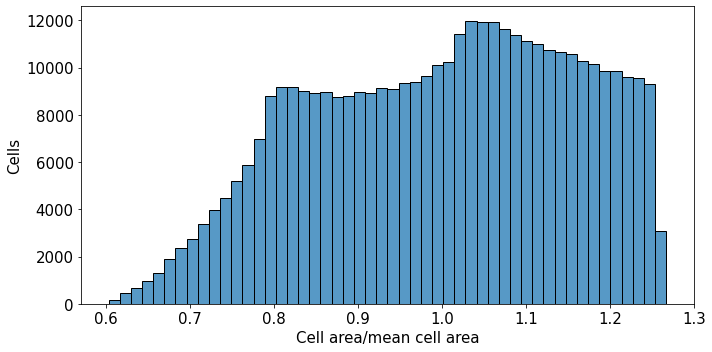

In [66]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cell area/mean cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\s2_area.png', bbox_inches="tight",dpi=300)

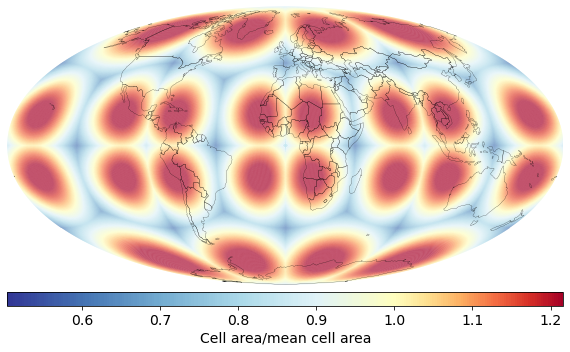

In [67]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\s2_area_map.png', bbox_inches="tight",dpi=300)

In [9]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='s2_8_clean', driver='GPKG')

### rhpix_5

In [7]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='rhpix_5_clean', driver='GPKG').dropna()

In [8]:
rhpix_graph = grid.drop('geometry',axis=1)

In [7]:
len(grid)

352654

In [140]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [141]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

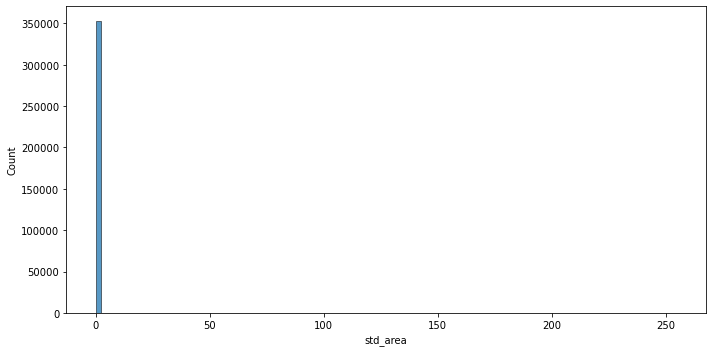

In [142]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=100)
plt.tight_layout()

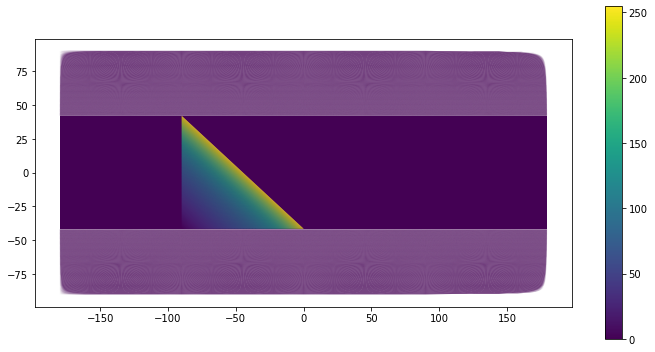

In [143]:
fig, ax = plt.subplots(figsize=(10,5))
grid.plot(column='std_area', ax=ax, legend=True)
plt.tight_layout()

#### Filter out weird tiny and huge cells

In [152]:
grid['ind_lambert_area'].quantile(0.9994)

1447456240.003654

In [155]:
grid = grid[(grid['ind_lambert_area'] > grid['ind_lambert_area'].quantile(0.000001))&(grid['ind_lambert_area'] < grid['ind_lambert_area'].quantile(0.9994))]

In [156]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

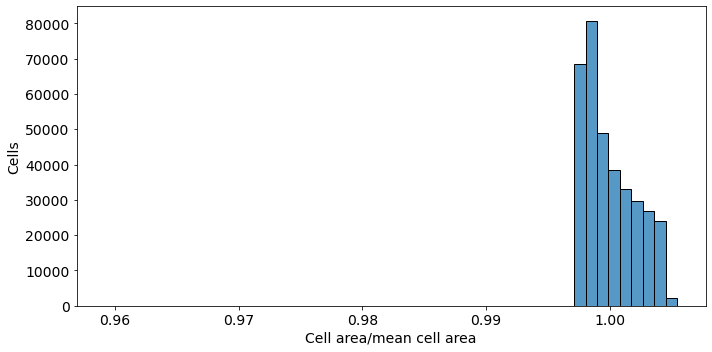

In [70]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('Cell area/mean cell area', fontsize=14)
ax.set_ylabel('Cells', fontsize=14)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\rhpix_area.png', bbox_inches="tight",dpi=300)

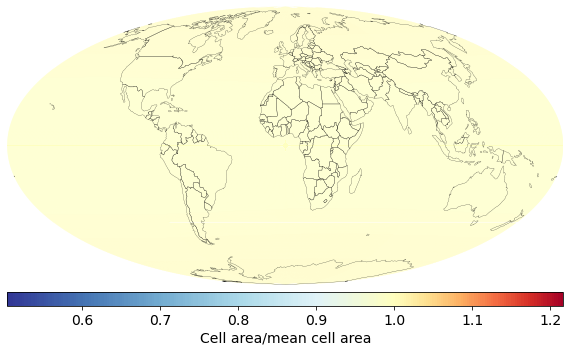

In [69]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, legend=True,cax=cax, norm=norm, cmap='RdYlBu_r', legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\rhpix_area_map.png', bbox_inches="tight",dpi=300)

In [159]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='rhpix_5_clean', driver='GPKG')

### EAGGR_4T_7

In [9]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='EAGGR4T_7_clean', driver='GPKG').dropna()

In [10]:
eaggr_graph = grid.drop('geometry',axis=1)

In [12]:
len(grid)

327680

In [11]:
grid

,ind_lambert_area,cell_id,lambert_perimeter,geometry
0,1.691252e+09,000000000,187488.677710,"POLYGON ((-144.00000 52.48367, -144.46512 52.9..."
1,1.427587e+09,000000001,173196.017200,"POLYGON ((-144.00000 53.38059, -144.46512 52.9..."
2,1.427656e+09,000000002,173199.707217,"POLYGON ((-144.46512 52.96915, -144.81311 52.5..."
3,1.427655e+09,000000003,173199.690332,"POLYGON ((-143.53488 52.96915, -144.00000 52.4..."
4,1.538313e+09,000000010,179016.034783,"POLYGON ((-144.00000 52.48367, -144.41725 52.0..."
...,...,...,...,...
327675,1.560365e+09,193333323,182395.666465,"POLYGON ((-144.60132 -27.92850, -144.00000 -28..."
327676,1.803396e+09,193333330,193891.083829,"POLYGON ((-144.00000 -27.19329, -144.60010 -27..."
327677,1.560590e+09,193333331,182498.726212,"POLYGON ((-145.00755 -27.00904, -144.60010 -27..."
327678,1.560542e+09,193333332,182496.953368,"POLYGON ((-144.60010 -27.45501, -144.00000 -27..."


In [15]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [16]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

C:\Users\Iam\Anaconda3\envs\dggs\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [57]:
grid[grid['ind_lambert_area'] < grid['ind_lambert_area'].quantile(0.00006)]

,ind_lambert_area,cell_id,lambert_perimeter,geometry,crossed,std_area
5456,1.304570e+09,001111100,166404.696092,"POLYGON ((-144.00000 89.09878, -156.18695 88.6...",False,0.838095
21840,1.304574e+09,011111100,166404.967547,"POLYGON ((-72.00000 89.09878, -84.18695 88.690...",False,0.838098
21845,1.304489e+09,011111111,166323.331562,"POLYGON ((0.00000 90.00000, -108.00000 89.5311...",False,0.838043
38224,1.304582e+09,021111100,166405.477771,"POLYGON ((0.00000 89.09878, -12.18695 88.69091...",False,0.838103
38229,1.304491e+09,021111111,166323.480171,"POLYGON ((0.00000 90.00000, -36.00000 89.53110...",False,0.838045
54608,1.304582e+09,031111100,166405.521282,"POLYGON ((72.00000 89.09878, 59.81305 88.69091...",False,0.838104
54613,1.304490e+09,031111111,166323.459368,"POLYGON ((0.00000 90.00000, 36.00000 89.53110,...",False,0.838045
70992,1.304575e+09,041111100,166405.037813,"POLYGON ((144.00000 89.09878, 131.81305 88.690...",False,0.838099
256642,1.304497e+09,152222002,166475.598229,"POLYGON ((-115.25213 -87.80490, -108.00000 -88...",False,0.838049
256672,1.304405e+09,152222200,166394.205015,"POLYGON ((-120.18695 -88.69091, -108.00000 -89...",False,0.837990


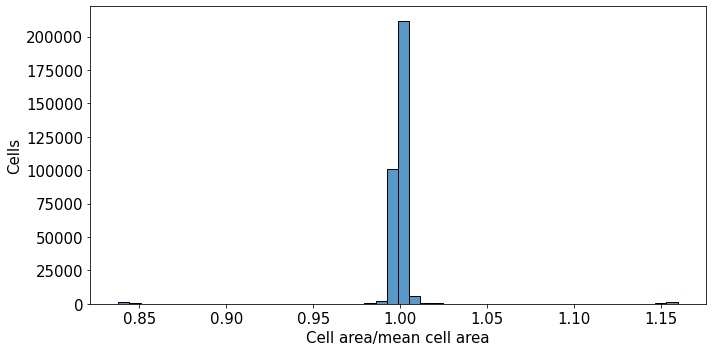

In [79]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cell area/mean cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\eaggr_area.png', bbox_inches="tight",dpi=300)

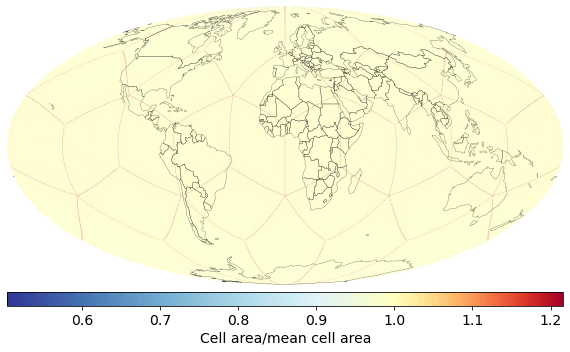

In [80]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\eaggr_area_map.png', bbox_inches="tight",dpi=300)

In [17]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='EAGGR4T_7_clean', driver='GPKG')

### DGGRID_ISEA4T_7

In [10]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA4T_7', driver='GPKG').dropna()

In [11]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [12]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

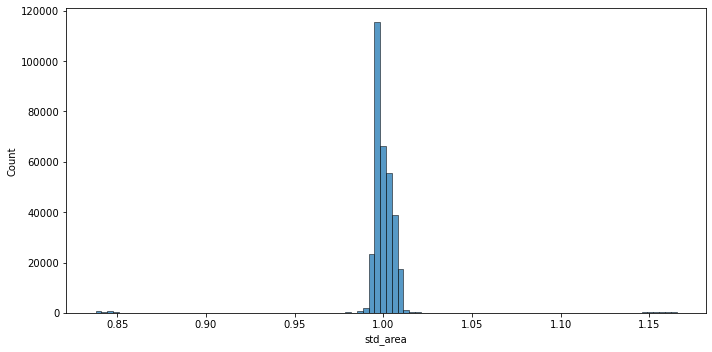

In [13]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
plt.tight_layout()

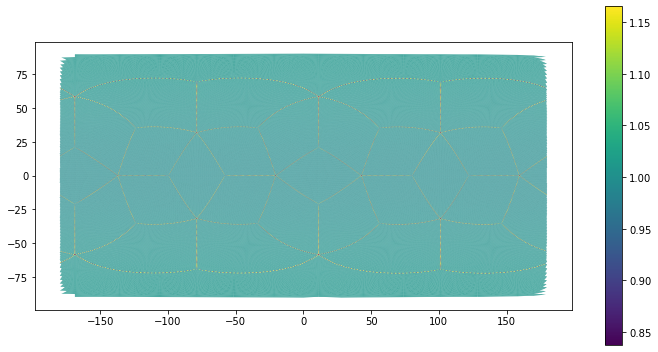

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
grid.plot(column='std_area', ax=ax, legend=True)
plt.tight_layout()

In [24]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA4T_7_clean', driver='GPKG')

### DGGRID_FULLER4T_7

In [126]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_FULLER_4T', driver='GPKG').dropna()

In [16]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [129]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

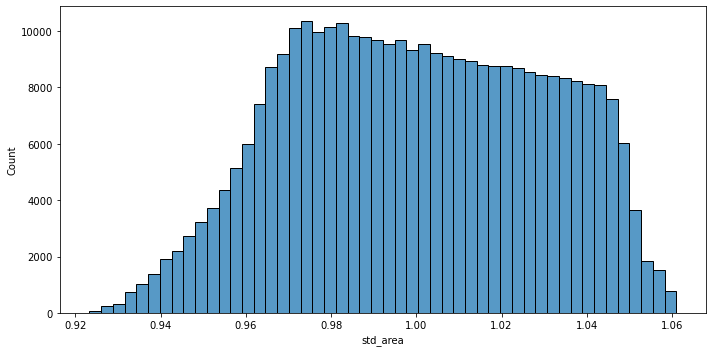

In [130]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
plt.tight_layout()

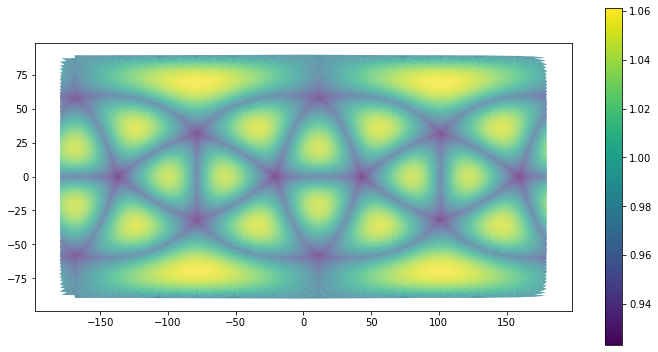

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
grid.plot(column='std_area', ax=ax, legend=True)
plt.tight_layout()

In [18]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_FULLER_4T_clean', driver='GPKG')

### DGGRID_ISEA7H_5

In [11]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA7H_5_clean', driver='GPKG').dropna()

In [12]:
ISEA7H_graph = grid.drop('geometry',axis=1)

In [17]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [18]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

In [32]:
grid['web_merc_area'] = grid.to_crs('EPSG:3857')['geometry'].area

In [34]:
grid['web_merc_area'] = grid['web_merc_area']/grid['web_merc_area'].mean() 

In [48]:
grid[grid['web_merc_area']>5]

,Name,ind_lambert_area,ind_UTM_area,goode_area,isea_area,crossed,std_area,lambert_perimeter,zsc,geometry,web_merc_area
18,19,3.061135e+09,3.058855e+09,3.041451e+09,1.731198e+12,False,1.008685,206638.122622,0.949149,"POLYGON ((-168.37982 80.34947, -170.21602 80.2...",5.700164
19,20,3.061449e+09,3.059134e+09,3.041407e+09,1.723594e+12,False,1.008789,206610.684077,0.949324,"POLYGON ((-168.32245 81.66909, -170.44036 81.5...",7.561096
20,21,3.061723e+09,3.059377e+09,3.041345e+09,1.715990e+12,False,1.008879,206587.866895,0.949471,"POLYGON ((-168.24310 82.99086, -170.74945 82.8...",10.527545
21,22,3.061955e+09,3.059583e+09,3.041246e+09,1.708386e+12,False,1.008955,206569.373736,0.949592,"POLYGON ((-168.12640 84.31444, -171.20151 84.2...",15.686269
22,23,3.062144e+09,3.059752e+09,3.041062e+09,1.700782e+12,False,1.009018,206554.964859,0.949688,"POLYGON ((-167.93825 85.63945, -171.92393 85.5...",25.880979
...,...,...,...,...,...,...,...,...,...,...,...
128894,129022,3.060725e+09,3.058410e+09,3.041618e+09,3.041637e+09,False,1.008550,206603.145197,0.949246,"POLYGON ((161.28677 -79.66589, 161.98363 -79.9...",5.344303
128895,129023,3.060706e+09,3.058411e+09,3.041623e+09,3.041637e+09,False,1.008544,206590.988211,0.949299,"POLYGON ((153.38447 -79.48251, 153.83968 -79.7...",5.201800
128941,129070,3.060626e+09,3.058437e+09,3.041603e+09,3.041637e+09,False,1.008518,206628.607480,0.949114,"POLYGON ((171.95114 -79.43270, 172.91792 -79.6...",5.055838
128942,129071,3.060675e+09,3.058272e+09,3.041616e+09,3.041637e+09,False,1.008534,206615.654802,0.949181,"POLYGON ((164.05069 -79.51345, 164.81578 -79.7...",5.175926


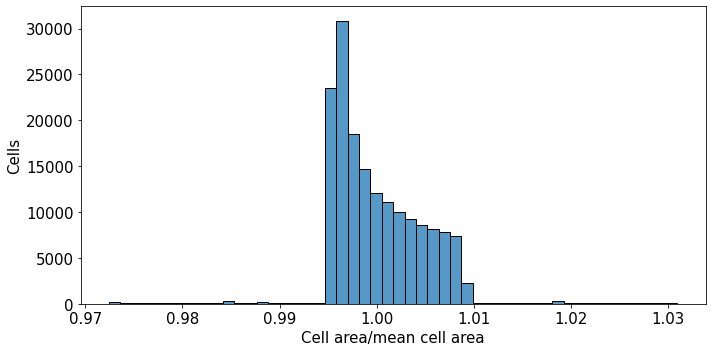

In [76]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid[grid['std_area'] > 0.95],x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cell area/mean cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\ISEA7H_area.png', bbox_inches="tight",dpi=300)

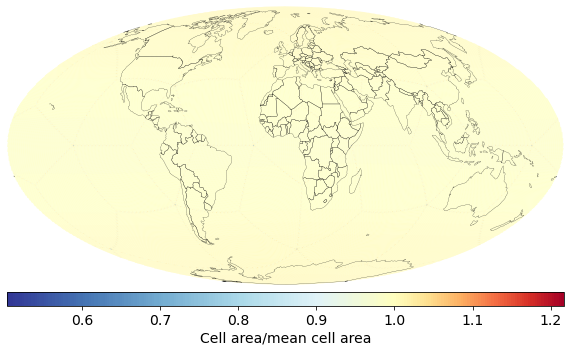

In [77]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\ISEA7H_area_map.png', bbox_inches="tight",dpi=300)

In [11]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA7H_5_clean', driver='GPKG')

### DGGRID_FULLER7H_5

In [13]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_FULLER_7H_clean', driver='GPKG').dropna()

In [14]:
Fuller7H_graph = grid.drop('geometry',axis=1)

In [123]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [124]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

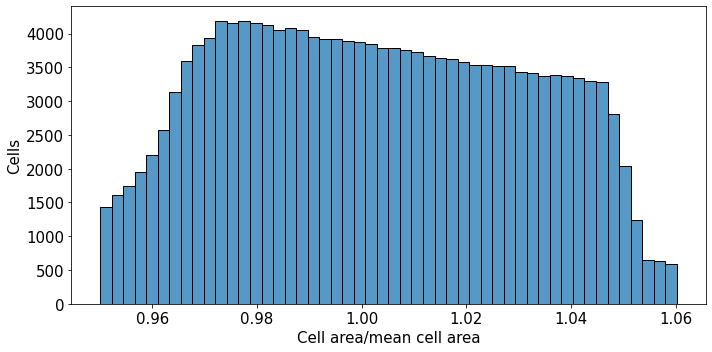

In [83]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid[grid['std_area'] > 0.95],x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cell area/mean cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\Fuller7H_area.png', bbox_inches="tight",dpi=300)

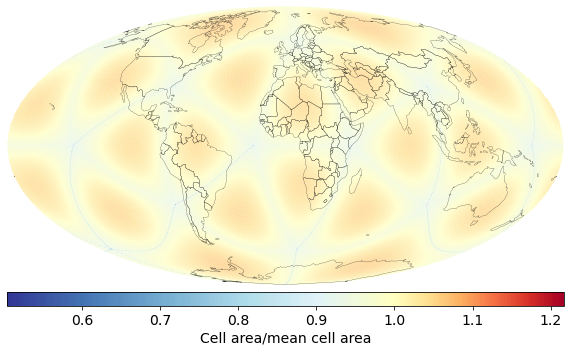

In [84]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\Fuller7H_area_map.png', bbox_inches="tight",dpi=300)

In [23]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_FULLER_7H_clean', driver='GPKG')

### DGGRID_ISEA3H_5

In [85]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA3H_9_clean', driver='GPKG').dropna()

In [82]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [83]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

In [58]:
grid[grid['ind_lambert_area'] > grid['ind_lambert_area'].quantile(0.99)]

,Name,ind_lambert_area,crossed,std_area,geometry
3916,3917,3.281342e+09,False,1.053994,"POLYGON ((-85.06474 75.13372, -85.89484 74.616..."
3917,3918,3.281894e+09,False,1.054171,"POLYGON ((-82.96936 75.18364, -83.86650 74.674..."
3918,3919,3.282204e+09,False,1.054271,"POLYGON ((-80.86256 75.21368, -81.82516 74.713..."
3919,3920,3.282272e+09,False,1.054293,"POLYGON ((-78.75000 75.22371, -79.77593 74.733..."
3920,3921,3.282098e+09,False,1.054237,"POLYGON ((-76.63744 75.21368, -77.72407 74.733..."
...,...,...,...,...,...
126771,126899,3.282256e+09,False,1.054288,"POLYGON ((109.32726 -65.36741, 110.65085 -65.2..."
126772,126900,3.281201e+09,False,1.053949,"POLYGON ((108.54232 -64.93662, 109.84964 -64.8..."
126893,127023,3.280860e+09,False,1.053839,"POLYGON ((114.11002 -66.93408, 115.48305 -66.8..."
126894,127024,3.280938e+09,False,1.053864,"POLYGON ((113.20493 -66.52749, 114.56334 -66.4..."


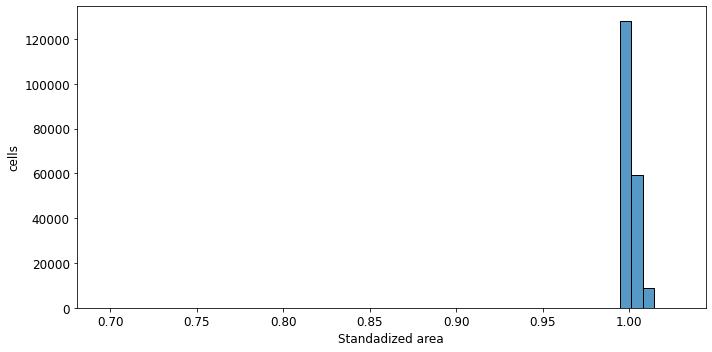

In [22]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel(' area', fontsize=12)
ax.set_ylabel('cells', fontsize=12)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\dggrid_isea3h_area.png', bbox_inches="tight",dpi=300)

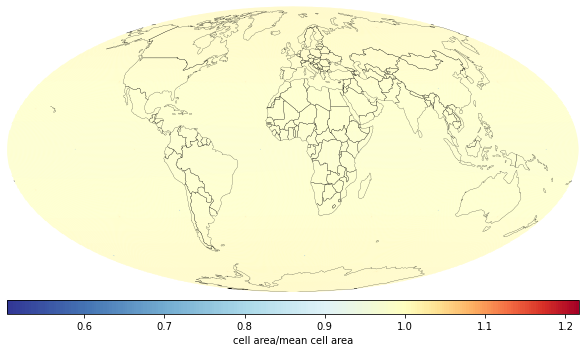

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\dggrid_isea3h_area_map.png', bbox_inches="tight",dpi=300)

In [56]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA3H_9_clean', driver='GPKG')

### DGGRID_ISEA4D_7

In [15]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA4D_7_clean', driver='GPKG').dropna()

In [116]:
len(grid)

163432

In [16]:
ISEA4D_graph = grid.drop('geometry',axis=1)

In [27]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [28]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

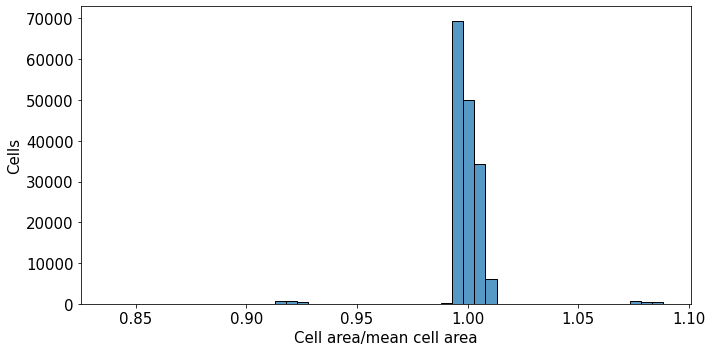

In [87]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('Cell area/mean cell area', fontsize=15)
ax.set_ylabel('Cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\dggrid_isea4D_area.png', bbox_inches="tight",dpi=300)

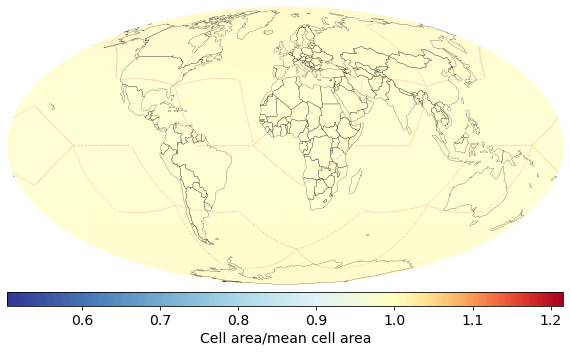

In [88]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\dggrid_isea4D_area_map.png', bbox_inches="tight",dpi=300)

In [29]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_ISEA4D_7_clean', driver='GPKG')

### DGGRID_FULLER_4D

In [17]:
grid = gpd.read_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_FULLER_4D_clean', driver='GPKG').dropna()

In [118]:
len(grid)

163432

In [18]:
Fuller4D_graph = grid.drop('geometry',axis=1)

In [39]:
# filter out broken geometries
grid['crossed'] = grid['geometry'].apply(check_for_geom)
grid = grid[~grid['crossed']]

In [40]:
grid['std_area'] = grid['ind_lambert_area']/grid['ind_lambert_area'].mean() 

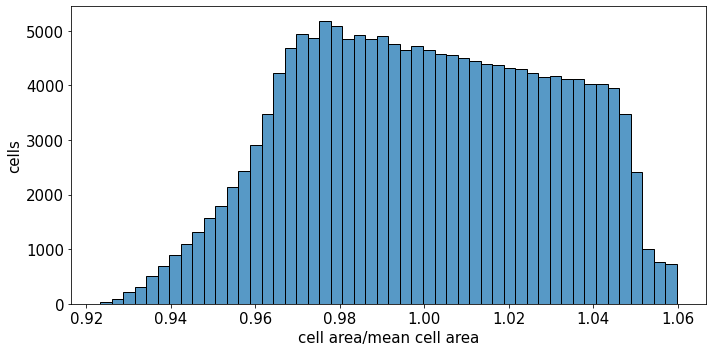

In [90]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(grid,x="std_area", ax=ax, bins=50)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_xlabel('cell area/mean cell area', fontsize=15)
ax.set_ylabel('cells', fontsize=15)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\dggrid_Fuller4D_area.png', bbox_inches="tight",dpi=300)

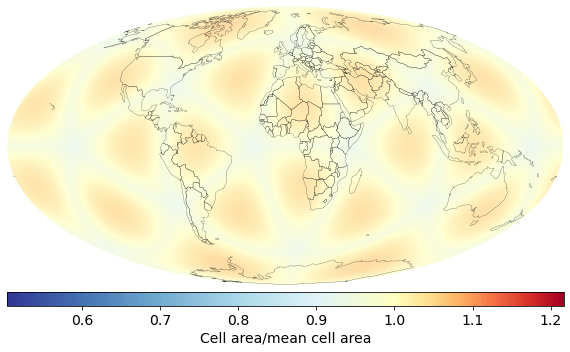

In [91]:
fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
grid.to_crs('proj=moll').plot(column='std_area', ax=ax, norm=norm, cmap='RdYlBu_r', legend=True,cax=cax, legend_kwds={'label': "cell area/mean cell area",'orientation': "horizontal"})
world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "Cell area/mean cell area",fontsize=14)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\dggrid_Fuller4D_area_map.png', bbox_inches="tight",dpi=300)

In [43]:
grid.to_file(r'd:\UTCloud\DGGS\grids\grids.gpkg', layer='DGGRID_FULLER_4D_clean', driver='GPKG')

### All stats graph

In [19]:
h3_graph['dggs'] = 'H3'

In [20]:
s2_graph['dggs'] = 'S2'

In [21]:
rhpix_graph['dggs'] = 'rHEALPix'

In [22]:
eaggr_graph['dggs'] = 'EAGGR'

In [23]:
Fuller4D_graph['dggs'] = 'Fuller4D'

In [24]:
ISEA4D_graph['dggs'] = 'ISEA4D'

In [25]:
ISEA7H_graph['dggs'] = 'ISEA7H'

In [26]:
Fuller7H_graph['dggs'] = 'Fuller7H'

In [27]:
for_graphs = pd.concat([h3_graph, s2_graph, rhpix_graph, eaggr_graph, ISEA7H_graph, Fuller7H_graph, ISEA4D_graph, Fuller4D_graph])

In [51]:
for_table = for_graphs.groupby('dggs').agg(cells=('ind_lambert_area','count'), std_area_min=('std_area','min'), std_area_max=('std_area','max'), std_area_mean=('std_area','mean'), std_area_median=('std_area','median'), 
                               std_area_deviation=('std_area','std'), zsc_min=('zsc','min'), zsc_max=('zsc','max'), zsc_mean=('zsc','mean'), zsc_median=('zsc','median'), zsc_deviation=('zsc','std')).reset_index()

KeyError: "Column 'ind_lambert_area' does not exist!"

In [53]:
for_graphs['resolution'] = [7,7,5,4,7,5,8,5]

In [59]:
for_graphs.round(4)

,cells,std_area_min,std_area_max,std_area_mean,std_area_median,std_area_deviation,zsc_min,zsc_max,zsc_mean,zsc_median,zsc_deviation,resolution
dggs,,,,,,,,,,,,
EAGGR,326656,0.8379,1.1595,1.0,1.0003,0.0189,0.7623,0.7776,0.7732,0.7742,0.0028,7
Fuller4D,163432,0.9233,1.0597,1.0,0.9994,0.0295,0.7932,0.8647,0.8229,0.8207,0.0191,7
Fuller7H,167635,0.7142,1.0602,1.0,0.9999,0.0314,0.8920,0.9523,0.9491,0.9495,0.0030,5
H3,287525,0.5041,1.2163,1.0,1.0170,0.1334,0.9299,0.9523,0.9511,0.9517,0.0016,4
ISEA4D,163432,0.8377,1.0883,1.0,0.9989,0.0121,0.7600,0.8536,0.8214,0.8328,0.0249,7
ISEA7H,167636,0.7319,1.0309,1.0,0.9989,0.0054,0.9299,0.9512,0.9470,0.9481,0.0033,5
S2,392703,0.6031,1.2672,1.0,1.0144,0.1544,0.8245,0.8862,0.8759,0.8794,0.0104,8
rHEALPix,352654,0.9592,1.0054,1.0,0.9994,0.0020,0.7224,0.8862,0.8676,0.8831,0.0289,5


In [60]:
for_graphs.reset_index().round(4).to_csv(r'D:\UTCloud\DGGS\results\desc_stats.csv', index=False)

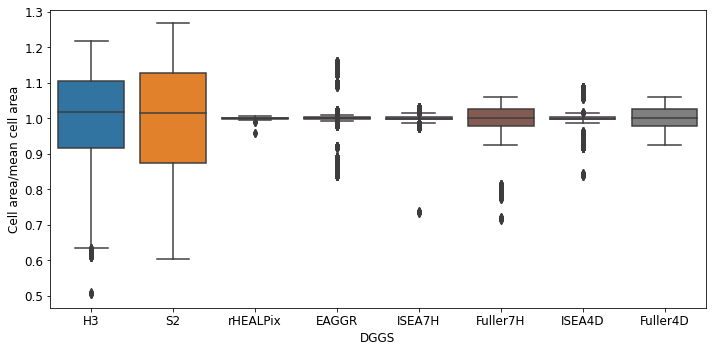

In [102]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=for_graphs,x="dggs", y='std_area', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('DGGS', fontsize=12)
ax.set_ylabel('Cell area/mean cell area', fontsize=12)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\box_plot_area.png', bbox_inches="tight",dpi=300)

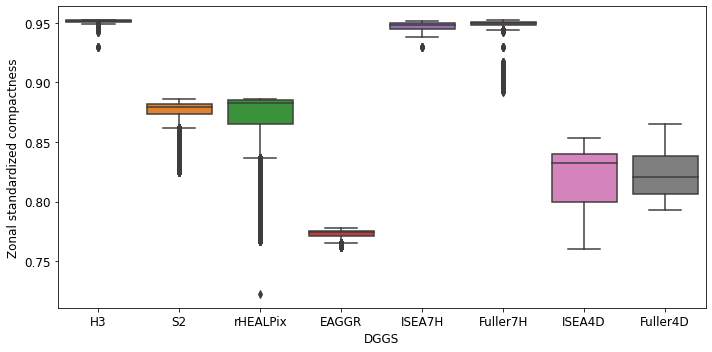

In [114]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=for_graphs,x="dggs", y='zsc', ax=ax)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('DGGS', fontsize=12)
ax.set_ylabel('Zonal standardized compactness', fontsize=12)
plt.tight_layout()
plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\box_plot_compactness.png', bbox_inches="tight", dpi=300)